# Аттестация

## Загрузка датасета

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atanaskanev/sqlite-sakila-sample-database")

print("Path to dataset files:", path)

/home/maksim/develops/python/MAKSIM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/maksim/.cache/kagglehub/datasets/atanaskanev/sqlite-sakila-sample-database/versions/1


#### Импорты

In [2]:
import sqlite3
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from psycopg2 import sql

from sqlalchemy.orm import sessionmaker
from database import engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px


#### Создание базы данных "sakila"

In [ ]:

# Параметры подключения
pg_user = "postgres"
pg_password = "postgres"
pg_host = "localhost"
pg_port = "5432"
pg_dbname = "sakila"

# Устанавливаем соединение с PostgreSQL (к базе данных postgres)
conn = psycopg2.connect(
    dbname="postgres",  # Подключаемся к стандартной базе данных postgres
    user=pg_user,
    password=pg_password,
    host=pg_host,
    port=pg_port
)

# Создаем курсор
cursor = conn.cursor()

conn.autocommit = True

# Создаем базу данных sakila
cursor.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier('sakila')))

# Закрываем курсор и соединение
cursor.close()
conn.close()

print("База данных 'sakila' успешно создана.")


База данных 'sakila' успешно создана.


#### Перенос данных из sqlite в Postgresql "sakila" 

In [7]:

# Подключение к SQLite
sqlite_db_path = "sakila.db"  # Путь к скачанной SQLite базе
sqlite_conn = sqlite3.connect(sqlite_db_path)

pg_engine = create_engine(f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_dbname}")

# Получение списка таблиц из SQLite
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, sqlite_conn)

# Перенос данных из каждой таблицы
for table_name in tables["name"]:
    df = pd.read_sql(f"SELECT * FROM {table_name}", sqlite_conn)
    df.to_sql(table_name, pg_engine, if_exists="replace", index=False)
    print(f"Таблица {table_name} успешно перенесена.")

# Закрываем соединения
sqlite_conn.close()
print("Перенос завершён!")


Таблица actor успешно перенесена.
Таблица country успешно перенесена.
Таблица city успешно перенесена.
Таблица address успешно перенесена.
Таблица language успешно перенесена.
Таблица category успешно перенесена.
Таблица customer успешно перенесена.
Таблица film успешно перенесена.
Таблица film_actor успешно перенесена.
Таблица film_category успешно перенесена.
Таблица film_text успешно перенесена.
Таблица inventory успешно перенесена.
Таблица staff успешно перенесена.
Таблица store успешно перенесена.
Таблица payment успешно перенесена.
Таблица rental успешно перенесена.
Перенос завершён!


## Задача 2 Подключение к БД и выполнение запросов

In [3]:
# Создаём папку "output"
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


In [4]:
# Создание сессии
Session = sessionmaker(bind=engine)
session = Session()


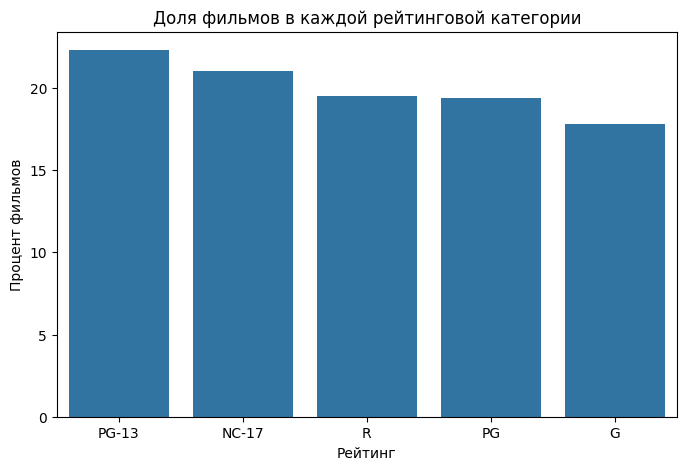

In [5]:

# 1 Доля фильмов в каждой рейтинговой категории
query_1 = """
SELECT rating, COUNT(*) * 100.0 / (SELECT COUNT(*) FROM film) AS percentage
FROM film
GROUP BY rating
ORDER BY percentage DESC;
"""
df_1 = pd.read_sql(query_1, engine)
df_1.to_csv("output/films_by_rating.csv", index=False)

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x=df_1["rating"], y=df_1["percentage"])
plt.title("Доля фильмов в каждой рейтинговой категории")
plt.ylabel("Процент фильмов")
plt.xlabel("Рейтинг")
plt.savefig("output/films_by_rating.png")
plt.show()

/tmp/ipykernel_21771/1178054635.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_2["rentals"], y=df_2["name"], palette="viridis")


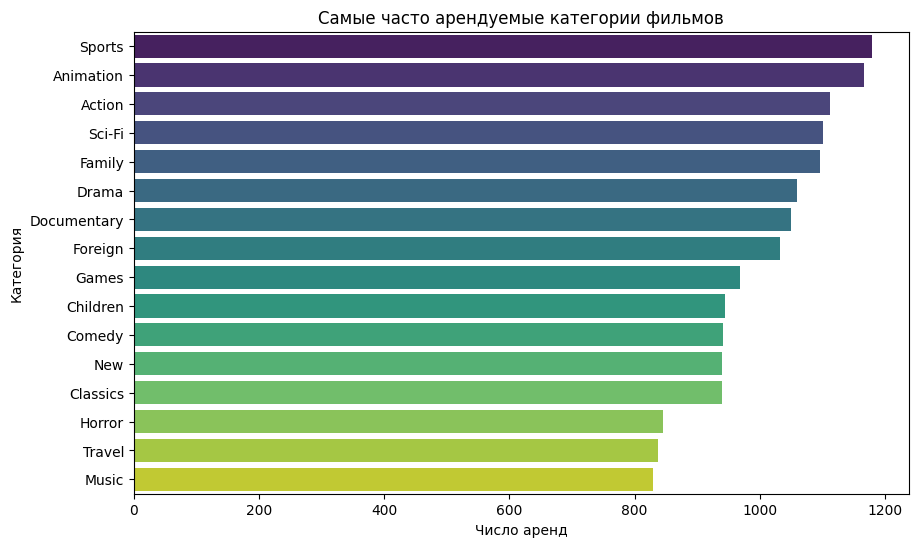

In [24]:
# 2  Какие категории фильмов чаще арендуются?
query_2 = """
SELECT c.name, COUNT(r.rental_id) AS rentals
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY rentals DESC;
"""
df_2 = pd.read_sql(query_2, engine)
df_2.to_csv("output/top_rented_categories.csv", index=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=df_2["rentals"], y=df_2["name"], palette="viridis")
plt.title("Самые часто арендуемые категории фильмов")
plt.xlabel("Число аренд")
plt.ylabel("Категория")
plt.savefig("output/top_rented_categories.png")
plt.show()

/tmp/ipykernel_21771/1370291913.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_3["avg_rental_duration"], y=df_3["name"], palette="coolwarm")


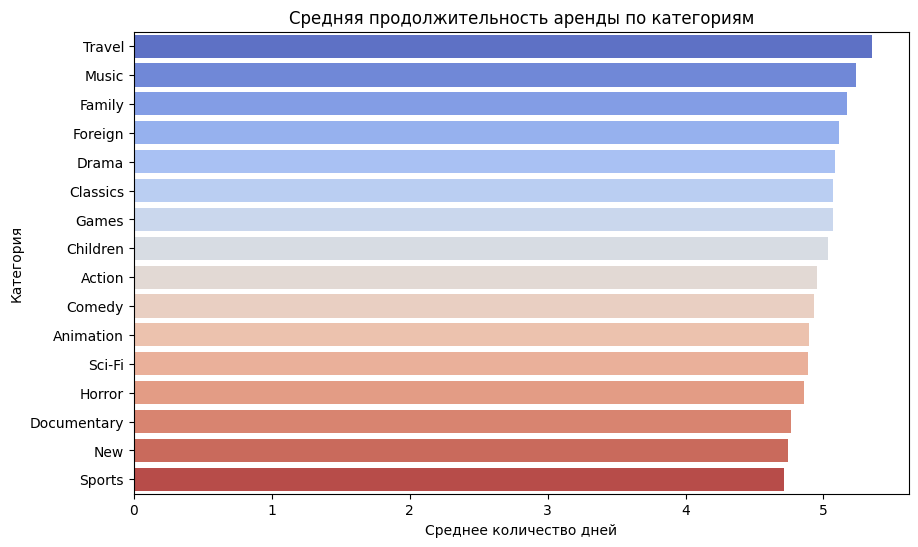

In [ ]:

# 3️ Средняя продолжительность аренды для каждой категории
query_3 = """
SELECT c.name, AVG(f.rental_duration) AS avg_rental_duration
FROM film f
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_rental_duration DESC;
"""
df_3 = pd.read_sql(query_3, engine)
df_3.to_csv("output/avg_rental_duration.csv", index=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=df_3["avg_rental_duration"], y=df_3["name"], palette="coolwarm")
plt.title("Средняя продолжительность аренды по категориям")
plt.xlabel("Среднее количество дней")
plt.ylabel("Категория")
plt.savefig("output/avg_rental_duration.png")
plt.show()



/tmp/ipykernel_21771/650071940.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("output/monthly_rental_revenue.png")
/home/maksim/develops/python/MAKSIM/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


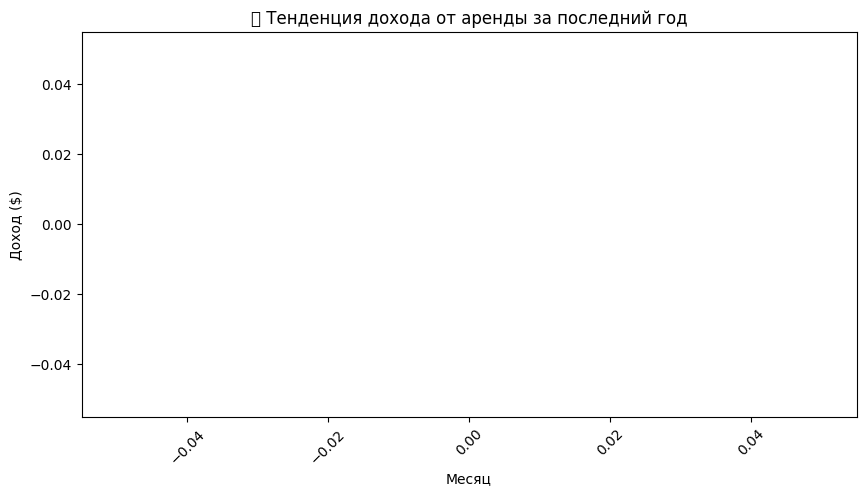

In [26]:
# 4 Тенденции за ежемесячный доход от продаж за предыдущий год
query_4 = """
SELECT DATE_TRUNC('month', payment_date) AS month, SUM(amount) AS revenue
FROM payment
WHERE payment_date >= NOW() - INTERVAL '1 year'
GROUP BY month
ORDER BY month;
"""
df_4 = pd.read_sql(query_4, engine)
df_4.to_csv("output/monthly_rental_revenue.csv", index=False)

# Визуализация тренда доходов по месяцам
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_4, x="month", y="revenue", marker="o")
plt.title("📊 Тенденция дохода от аренды за последний год")
plt.xlabel("Месяц")
plt.ylabel("Доход ($)")
plt.xticks(rotation=45)
plt.savefig("output/monthly_rental_revenue.png")
plt.show()


In [6]:
import plotly.express as px
import pandas as pd

# SQL-запрос: сумма продаж по магазинам
query_5 = """
SELECT s.store_id, SUM(p.amount) AS total_sales
FROM payment p
JOIN rental r ON p.rental_id = r.rental_id
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN store s ON i.store_id = s.store_id
GROUP BY s.store_id
ORDER BY total_sales DESC;
"""

# Выполняем запрос
df_5 = pd.read_sql(query_5, engine)
df_5.to_csv("output/sales_by_store.csv", index=False)

# Создаём круговую диаграмму
fig = px.pie(
    df_5,
    values="total_sales",
    names="store_id",
    title="Доля продаж по магазинам",
    hole=0.2,  # Делаем пончик-диаграмму
    color_discrete_sequence=px.colors.sequential.RdBu,  # Красиво раскрашиваем
    width=800,
    height=600
)

# Сохранение и отображение
fig.write_html("output/sales_by_store_piechart.html")  # Сохранение в HTML
fig.show()


/tmp/ipykernel_21771/4063285897.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_6, x="avg_replacement_cost", y="name", palette="viridis")
/tmp/ipykernel_21771/4063285897.py:18: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig("output/avg_replacement_cost_by_genre.png")
/home/maksim/develops/python/MAKSIM/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


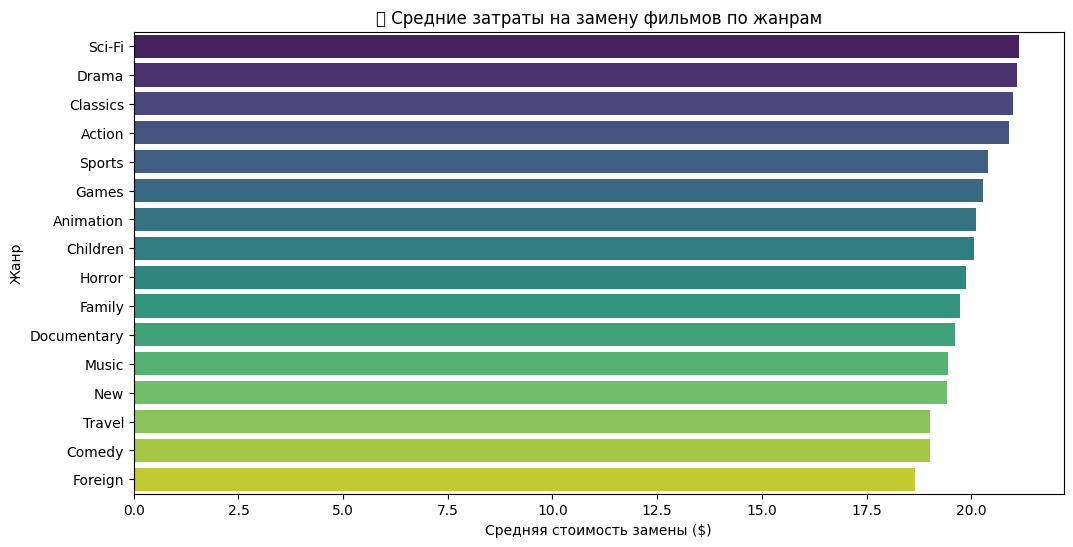

In [28]:
# 6 Стоимость замены фильма
query_6 = """
SELECT c.name, AVG(f.replacement_cost) AS avg_replacement_cost
FROM film f
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_replacement_cost DESC;
"""
df_6 = pd.read_sql(query_6, engine)
df_6.to_csv("output/avg_replacement_cost_by_genre.csv", index=False)

# Визуализация стоимости замены фильмов
plt.figure(figsize=(12, 6))
sns.barplot(data=df_6, x="avg_replacement_cost", y="name", palette="viridis")
plt.title("Средние затраты на замену фильмов по жанрам")
plt.xlabel("Средняя стоимость замены ($)")
plt.ylabel("Жанр")
plt.savefig("output/avg_replacement_cost_by_genre.png")
plt.show()


In [7]:


# SQL-запрос: считаем количество уникальных жанров для всех актеров
query_7 = """
SELECT a.actor_id, a.first_name, a.last_name, COUNT(DISTINCT c.category_id) AS unique_genres
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
JOIN film_category fc ON fa.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY unique_genres DESC;
"""

# Выполняем запрос и сохраняем в DataFrame
df_7 = pd.read_sql(query_7, engine)
df_7["actor_name"] = df_7["first_name"] + " " + df_7["last_name"]
df_7.to_csv("output/all_actors_by_genres.csv", index=False)

# Построение круговой диаграммы с Plotly**
fig = px.pie(
    df_7,
    values="unique_genres",
    names="actor_name",
    title=" Все актёры, снимающиеся в разных жанрах",
    hole=0.2,  # Делаем диаграмму "пончиком"
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    width=1000,  # Ширина графика
    height=800   # Высота графика
)

# # Сохранение и показ графика
fig.write_image("output/actors_by_genres_piechart_all.png")
fig.show()


In [8]:
df_7 = df_7.head(40) 
# Построение круговой диаграммы с увеличенным размером
fig = px.pie(
    df_7,
    values="unique_genres",
    names="actor_name",
    title=" Топ-40 актёров по количеству жанров фильмов",
    hole=0.2,  # Делаем диаграмму "пончиком"
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    width=1200,  # Ширина графика
    height=800   # Высота графика
)
fig.write_html("output/actors_by_genres_piechart.html")
fig.show()


## Задача 3. Статистический анализ и визуализация данных